# HW4P1: Language Modelling

Welcome to the final part 1 hw of this course. This is the only part 1 in which you have PyTorch training (Yay). You will be working on training language models and evaluating them on the task of prediction and generation.<br>
Note: A major change which we have made this semester is that we have made the model which you will be coding in this HW very similar to the Speller module from HW4P2. 

# Get modules and datasets

In [ ]:
!pip install torchsummaryX

In [94]:
# TODO: Import drive if you are using Colab

# Imports

In [2]:
import sys
sys.path.append("/content/handout") # TODO: Add path to handout/

In [3]:
!pwd

/content


In [4]:
%matplotlib inline

import torch

import os

import time 
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import torchsummaryX

# Importing necessary modules from hw4
from hw4.tests_hw4 import test_prediction, test_generation

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", DEVICE)

%cd handout

Device:  cuda
/content/handout


In [5]:
!pwd

/content/handout


# Load datasets

In [42]:
# Loading the vocabulary. Try printing and see
VOCAB       = np.load('dataset/vocab.npy') 
print(VOCAB.shape)
# We have also included <sos> and <eos> in the vocabulary for you
# However in real life, you include it explicitly if not provided
SOS_TOKEN   = np.where(VOCAB == '<sos>')[0][0]
EOS_TOKEN   = np.where(VOCAB == '<eos>')[0][0]
NUM_WORDS   = len(VOCAB) - 2 # Actual number of words in vocabulary

print("Vocab length: ", len(VOCAB))
print(VOCAB)
print(SOS_TOKEN)
print(EOS_TOKEN)

(33280,)
Vocab length:  33280
['!' '"' '#' ... '～' '<sos>' '<eos>']
33278
33279


In [43]:
# Loding the training dataset. Refer to write up section 2 to understand the structure
dataset     = np.load('dataset/wiki.train.npy', allow_pickle=True)

# Before doing do, try printing the dataset to see if they are words or integers.
# for i in range(10):
#   print(dataset[i])

# The dataset does not have <sos> and <eos> because they are just regular articles. 
# Add <sos> and <eos> to every article in the dataset.
for i in range(len(dataset)):
  dataset[i] = np.concatenate(([SOS_TOKEN], dataset[i], [EOS_TOKEN]))

for i in range(10):
  print(dataset[i])

[33278  1420 13859 ...    79  1417 33279]
[33278  1420 13463 ...    79  1417 33279]
[33278  1420  1419 ...   743  1417 33279]
[33278  1420  5925 33004    64 25399 21405 31205  1420  1417 13276  5925
 33004    64 25399 21405 31205 28489 31353  5925 22968 23428 21405 17840
    79 13276 31205    76 22678    76 22324 25639 17835 22968 14658 24686
 28034 16802  5361    76 31353 30248    64 23428 21986 16457    76 19149
 31352 25990 33004    64 21405 22324 16176 26808 22968 31353 18425 29755
   785    79 13276  5925 22324 31994 33150 31210    76 15310 32084  1424
   460 29691 31352 22324 17835 22968  5361 13689  1424   460 14397    64
 14424  4296 27696    76 15340 15310 32084  1424   664 29691 31352 32984
 21626 28207 27696 21415 15310 32084  1424   664 14424  4296    79 13276
 19211 25821 14658 25399 31205 20850 17189 29736 31543 31435 14842  1626
    76 15238 31353 25399 21405 15741 22324 21532 30323 24807 21372 25871
 33004    64 21405    79  1417  1420  1420 13276 31205  1420  1420  141

In [44]:
# Loading the fixtures for validation and test - prediction
fixtures_pred       = np.load('fixtures/prediction.npz')        # validation
fixtures_pred_test  = np.load('fixtures/prediction_test.npz')   # test

print(type(fixtures_pred))
print("Validation shapes    : ", fixtures_pred['inp'].shape, fixtures_pred['out'].shape)
print("Test shapes          : ", fixtures_pred_test['inp'].shape)

<class 'numpy.lib.npyio.NpzFile'>
Validation shapes    :  (128, 21) (128,)
Test shapes          :  (128, 21)


In [45]:
# Loading the fixtures for validation and test - generation
fixtures_gen        = np.load('fixtures/generation.npy')        # validation
fixtures_gen_test   = np.load('fixtures/generation_test.npy')   # test

print("Validation Gen Shapes    :", fixtures_gen.shape)
print("Test Gen Shapes          :", fixtures_gen_test.shape)

Validation Gen Shapes    : (32, 21)
Test Gen Shapes          : (128, 31)


In [46]:
# Example Prediction Dev Input and Output
# Optional TODO: You can try printing a few samples from the validation set which has both inputs and outputs
for i in range(10):
  print(fixtures_pred['inp'][i])
  print(fixtures_pred['out'][i])


[33278 26096 26972 25821 14658 29325 32935 21820 25639 16134 31353 29092
    79  6916    76 21415 14658 24911  1424 29456 29325]
72
[33278 14658 21076 21626 31353  6613  1419 10706 15340 25874 25949 31994
 21626  2299  3952    79  1419    76  1184 31543  1242]
24820
[33278  1419 15219 27351 25131 21415 32352 25871 31353 28863    76 31353
 21201 31994 25821 32883 19278 21626 31353 25806  1424]
21959
[33278  6591 25821  1419    79 12269 22213 16176 18272 21626 14658 17765
 32503 22968  9810 10184 21415 28860 15340 17575 21114]
79
[33278 31353 21111 28343 18250    76 15659  1419 31326 27001 21415 20086
 24118 25821  1419 27297 31543 22534 25537 21111    79]
1419
[33278 31353 32715    76 16786 31399 32846 28744 15039  9224    79 10696
 21415 25177 20037  1419 32846 28262 25871 31353 22122]
25821
[33278 23039 25949 18869 22968 31891 18709 23374    79 12559 31891 18710
  1419 22968 30596 25177 31348 31353   792  1425  1114]
13052
[33278 32747 31136 32978 14658 21076 19825 32899 18395 28456 2

# Custom DataLoader

In [145]:
class DataLoaderForLanguageModeling(torch.utils.data.DataLoader): # Inherit from torch.utils.data.DataLoader
    """
        TODO: Define data loader logic here
    """
    # TODO: You can probably add more parameters as well. Eg. sequence length
    def __init__(self, dataset, batch_size, sequence_length, shuffle= True, drop_last= False): 
        
        # If you remember, these are the standard things which you give while defining a dataloader.
        # Now you are just customizing your dataloader
        self.dataset    = dataset
        self.batch_size = batch_size
        self.sequence_length = sequence_length
        self.shuffle    = shuffle
        self.drop_last  = drop_last
        # Shuffle data if shuffle is True
        if self.shuffle:
            np.random.shuffle(dataset)
        
        # Concatenate articles
        self.dataset = np.concatenate(dataset, axis=0)

        self.num_batches = len(self.dataset) // (self.batch_size * self.sequence_length)


    def __len__(self):
        # What output do you get when you print len(loader)? You get the number of batches
        # Your dataset has (579, ) articles and each article has a specified amount of words.
        # You concatenate the dataset and then batch parts of it according to the sequence length
        # TODO: return the number of batches
        # If you are using variable sequence_length, the length might not be fixed 
        return self.num_batches

    def __iter__(self):
        # 1. Shuffle data if shuffle is True
        # 2. Concatenate articles and drop extra words
        # 3. Divide the concetenated dataset into inputs and targets. How do they vary? 
        # 4. Reshape the inputs and targets into batches (think about the final shape)
        # 5. Loop though the batches and yield the input and target according to the sequence length

        # Divide the concetenated dataset into inputs and targets. How do they vary?
        batch_idx = 0
        inputs = []
        targets = []
        input_length = self.batch_size * self.sequence_length

        for i in range(self.num_batches):
          inputs = self.dataset[i*input_length:(i+1)*input_length]
          targets = self.dataset[i*input_length+1:(i+1)*input_length+1]
          inputs = torch.tensor(inputs, dtype=torch.long)
          targets = torch.tensor(targets, dtype=torch.long)
          inputs = inputs.reshape(((self.batch_size, self.sequence_length)))
          targets = targets.reshape(((self.batch_size, self.sequence_length)))
          yield inputs, targets

In [114]:
# Some sanity checks

dl = DataLoaderForLanguageModeling(
    dataset     = dataset, 
    batch_size  = 32,
    sequence_length= 3, # TODO 
    shuffle     = True, 
    drop_last   = True
    # Input Extra parameters here if needed
)

inputs, targets = next(iter(dl))
print(inputs.shape, targets.shape)

for x, y in dl:
    print("x: ", [VOCAB[i] for i in x[0, :]])
    print("y: ", [VOCAB[i] for i in y[0, :]])
    break

torch.Size([32, 3]) torch.Size([32, 3])
x:  ['<sos>', '=', 'Trials']
y:  ['=', 'Trials', 'and']


# LanguageModel

In [115]:
# # an Embedding module containing 10 tensors of size 3
# embedding = torch.nn.Embedding(10, 3)
# # a batch of 2 samples of 4 indices each
# input = torch.LongTensor([[1, 2, 4, 5], [4, 3, 2, 9]])
# # xdoctest: +IGNORE_WANT("non-deterministic")
# embedding(input).shape

In [116]:
# batch_size = 3
# seq_len = 4
# x = torch.randn(batch_size, seq_len)
# # print(x)
# next_token = torch.randn(batch_size,)
# next_token = next_token.reshape(-1, 1)
# # print(next_token)
# concatenated_sequence = torch.cat((x, next_token), dim=1)
# # print(concatenated_sequence)
# vocab_size = 7
# y = torch.randn(batch_size, vocab_size)
# # print(y)
# next_token = torch.argmax(y, dim=1)
# print(next_token)
# print(next_token.shape)
# generated_sequence = [next_token]
# timesteps = 5
# for i in range (timesteps):
#   generated_sequence.append(next_token)
# print(generated_sequence)
# generated_sequence = torch.stack(generated_sequence, dim= 1)
# print(generated_sequence)
# print(generated_sequence.shape)
# print(next_token[:2])

In [127]:
# Here comes the main portion of this HW.
# You can do this with a regular LSTM similar to HW3P2. 
# However, using LSTMCells will make this Language model very similar to the decoder in HW4P2 and we recommend you use that for writing resuable code.

class LanguageModel(torch.nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_size, num_lstm_layers): # TODO: Add more parameters if you want
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.num_lstm_layers = num_lstm_layers

        # For all the layers which you will define, please read the documentation thoroughly before implementation

        self.token_embedding    = torch.nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=self.embedding_dim) # Define a PyTorch embedding layer 

        self.lstm_cells = torch.nn.Sequential()
        for layer in range(self.num_lstm_layers):
            self.lstm_cells.append(torch.nn.LSTMCell(input_size=self.embedding_dim if layer == 0 else self.hidden_size, hidden_size=self.hidden_size))


        self.token_probability  = torch.nn.Linear(in_features=self.hidden_size, out_features=self.vocab_size) # Define the parameters

        

        # Weight Tying. You just need to make the embedding layer weights equal to the Linear layer weight. 
        # https://piazza.com/class/lbz3z9om43h2n3/post/1164_f6
        self.token_embedding.weight   = self.token_probability.weight
                
        # So the basic pipline is:
        # word -> embedding -> lstm -> projection (linear) to get  probability distribution
        # And this is happening across all time steps

    def rnn_step(self, embedding, hidden_states_list):
      """
      This method iterates over our LSTMCell layers defined in self.lstm_cells.
      At each iteration, our LSTMCell layers take in a token embedding at timestep
      t and the hidden state at each layer and computes the next hidden state. 
      
      The method returns the final hidden state output and our final list of hidden states
      """
      # input = (batch_size, seq_len)
      # embedding = (batch_size, seq_len, embedding_dim)

      # iterate over our LSTMCell layers
      for i in range(len(self.lstm_cells)):
          # get the hidden state list for the layer if it is present
          if hidden_states_list[i] is not None:
            hidden_state, cell_state = hidden_states_list[i]
          else:
            # initialize
            hidden_state = torch.zeros((embedding.shape[0], self.hidden_size)).to(DEVICE)
            cell_state = torch.zeros((embedding.shape[0], self.hidden_size)).to(DEVICE)

          # Forward pass through each LSTMCell
          # Obtain the embedding and hidden_state
          hidden_state, cell_state = self.lstm_cells[i](embedding, (hidden_state, cell_state))
          hidden_states_list[i] = (hidden_state, cell_state)
          # the embedding for the next layer will be the hidden state of the current layer
          embedding = hidden_state # (batch_size, hidden_size)
      
      final_hidden_state_output = embedding
      return final_hidden_state_output, hidden_states_list

    def predict(self, x):
        """
        The LM learns to compute P(T_k+1 | <sos>, T_1, T_2, ... , T_k ; \theta) 
        i.e. the probability distribution of the next token sequence T_k+1, given
        the entire sequence until the current token T_k. If the LM has been trained
        well and has learned the structure of the language well, it would ideally
        assign the highest probability to the TRUE next token. 

        Supervised testing - For a large test set of partial token sequences T_1 to T-k
        where we also know the next token T_k+1, compute the probability distribution for
        the (k+1)th token. If over the entire test set, the average "predicted" log probability
        for the last token (in the sequence) is large enough, the LM may have been well estimated
        """
        # x.shape = (batch_size, sequence_len)
        if not torch.is_tensor(x):
            x = torch.tensor(x).long().to(DEVICE)

        """
        Return your model's guess of what the next token might be. The model will be evaluated based 
        on the scores it assigns to the actual next token in the test data.
        """
        with torch.inference_mode():
            # Pass the input sequence through the model - perform a forward pass
            model_out, _ = self.forward(x) # model_out.shape = (batch_size, timesteps, vocab_size)

            # and return the probability distribution (scores) for the last timestep
            final_out = model_out[:, -1, :] # final_out.shape = (batch_size, vocab_size)
            return final_out

    def generate(self, x, timesteps):
        """
        Given a partial token sequence, use the LM to extend N tokens (N=timesteps)
        in the sequence (or to complete the sequence). This function requires sampling
        the output at one timestep and incorporate that in the input to the next timestep.
        """
        # x = (batch_size, sequence_len)
        # sequence_len = K, timesteps = N
        # Refer to section 1.3.2 to understand this function
        # Important Note: We do not draw <eos> from the distribution unlike the writeup
        if not torch.is_tensor(x):
            x = torch.tensor(x).long().to(DEVICE)

        # Pass the input sequence through the model to get both the predicted distribution 
        # for the next token and the hidden states for all cells
        token_prob_distribution, hidden_states_list = self.forward(x)
        # token_prob_dist = (batch_size, sequence_len, vocab_size)

        # Obtain the probability distribution and hidden_states_list of the last timestep
        next_token_prob_distribution = token_prob_distribution[:, -1, :] # (batch_size, vocab_size)

        # Draw the next predicted token from the probability distribution 
        next_token = torch.argmax(next_token_prob_distribution, dim=1) # (batch_size, ) returns a list of <batch_size> indices where each index in a batch is the token with the highest probability 

        generated_sequence  = [next_token] 
        current_context = x
        with torch.inference_mode():
            for t in range(timesteps): # Loop through the timesteps = N

                # Pass the next_token and hidden_states_list through the mode
                """
                Select appropriate context for the next token, the next token will depend on all the tokens before it
                So concatenate next_token to current context and then pass the concatenated sequence through the model to compute the
                new total_probability distribution. We should not draw <sos> or <eos> from the vocabulary, although our vocabulary and
                embedding layer will include it. We are required instead to generate for a fixed number of timesteps N
                """
                # x = (batch_size, sequence_len)
                # next_token = (batch_size, )
                next_token_reshaped = next_token.reshape(-1, 1) # reshape token to have matching dims (batch_size, 1)
                current_context = torch.cat((current_context, next_token_reshaped), dim=1) # concatenate along the sequence_len dimension

                token_prob_distribution, hidden_states_list = self.forward(current_context, hidden_states_list) 
                # What is the shape of the probability distribution? (batch, sequence_len+t, vocab_size)
                
                # Get the most probable token for the next timestep. When drawing tokens for completion,
                # draw from the probability distribution without including <sos> and <eos>. We can do this
                # by slicing the probability distribution by the actual number of words in the vocabulary
                # before drawing
                next_token_prob_distribution = token_prob_distribution[:, -1, :NUM_WORDS] # (batch_size, vocab_size-2) ; excluding <sos> and <eos>
                next_token = torch.argmax(next_token_prob_distribution, dim=1) # (batch_size, )

                generated_sequence.append(next_token) # (timesteps, batch_size)


            
            # reshape to (batch_size, timesteps)
            generated_sequence = torch.stack(generated_sequence, dim= 1) # keep last timesteps generated words

        return generated_sequence

    # We are also having a hidden_states_list parameter because you need that in generation
    def forward(self, x, hidden_states_list= None): # train model
        """
        compute the probability of a complete token sequence
        ensure <sos> and <eos> are included
        """
        # x (batch_size, sequence_len)
        # Note: you dont have to return the sum of log probabilities according to Pseudocode 1 in the writeup
        # However, feel free to calculate and print it if you are curious
        if not torch.is_tensor(x):
            x = torch.tensor(x).long().to(DEVICE)

        batch_size, timesteps   = x.shape 

        token_prob_distribution = [] # list which will contain probability distributions for all timesteps
        # Initializing the hidden states. 
        hidden_states_list      = [None]*self.num_lstm_layers if hidden_states_list is None else hidden_states_list

        # first obtain the embedding of input x
        token_embeddings        = self.token_embedding(x)  # (batch_size, timesteps, embedding_dim)
        # When you get the embeddings of the input x, remember that you get it for all time steps.
        # Embedding is just a linear transformation so you can precompute it for all time steps.

        # iterate over all the tokens in our sequences
        for t in range(timesteps): # LSTMCell is for just 1 timestep. Hence you need to loop through the total timesteps

            # get the embedding of input at the current timestep. you don't need to get the embeddings UPTO the current timesteps since the RNN hidden states will capture that information
            token_embedding_t           = token_embeddings[:, t, :] # (batch_size, 1, embedding_dim)

            # feed the embedding throught all LSTM cells and retrieve the final hidden state output and final list of hidden states
            rnn_out, hidden_states_list = self.rnn_step(token_embedding_t, hidden_states_list) # (What should you do with the hidden_states_list?)
            # rnn_out = (batch, hidden_size)
            
            # map the RNN output to the vocabulary's dimension and store it in the token probability distribution at time t
            token_prob_dist_t           = self.token_probability(rnn_out) # (batch_size, vocab_size)

            token_prob_distribution.append(token_prob_dist_t) # (timesteps, batch_size, vocab_size)

        token_prob_distribution = torch.stack(token_prob_distribution, dim=1) # Stack along the timesteps dimension (batch_size, timesteps, vocab_size)

        return token_prob_distribution, hidden_states_list 

In [118]:
# t = 4
# b = 2
# v = 10
# a = np.random.randn(t, b, v)
# print(a.shape)
# a_d = np.stack(a, axis=1)
# print(a_d.shape)
# last_token_prob = a_d[:, -1, :]
# print(last_token_prob.shape)
# next_token = np.argmax(last_token_prob, axis=1)
# print(next_token.shape)
# next_token = next_token.reshape(-1, 1)
# print(next_token.shape)

# Trainer Class

In [119]:
# a_test = torch.randn(3, 4, 7)
# print(a_test.shape[-1])
# b_test = torch.randn(3,4)
# print(b_test.reshape(-1, 1).shape)

In [128]:
# Mixed Precision, if you need it
scaler = torch.cuda.amp.GradScaler()

In [130]:
# Unlike all the P2s, we are using a Trainer class for this HW.
# Many researchers also use classes like this for training. You may have encountered them in your project as well.
# You dont have to complete everything in this class, you only need to complete the train function.
# However, its good to go through the code and see what it does. 

class Trainer:
    def __init__(self, model, loader, optimizer, criterion, scheduler, max_epochs= 1, run_id= 'exp'):
        """
            Use this class to train your model
        """
        # feel free to add any other parameters here
        self.model      = model
        self.loader     = loader
        self.optimizer  = optimizer
        self.criterion  = criterion
        self.scheduler  = scheduler

        self.train_losses           = []
        self.val_losses             = []
        self.predictions            = []
        self.predictions_test       = []
        self.generated_logits       = []
        self.generated              = []
        self.generated_logits_test  = []
        self.generated_test         = []
        self.epochs                 = 0
        self.max_epochs             = max_epochs
        self.run_id                 = run_id


    def calculate_loss(self, out, target):
        # output: (B, T, Vocab_size) - probability distributions
        # target: (B, T)
        # Read the documentation of CrossEntropyLoss and try to understand how it takes inputs
        # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
        """
        The input is expected to contain the unnormalized logits for each class 
        (which do not need to be positive or sum to 1, in general). input has to be a Tensor of size (C)
        for unbatched inputs, (minibatch, C) for batched inputs where C = # of classes = Vocab_size
        """

        # Tip: If your target is of shape (B, T) it means that you have B batches with T words. 
        # Tip: What is the total number of words in this batch? B * T
        # Tip: Crossentropy calculates the loss between a label and its probability distribution.

        out     = out.reshape(-1, out.size(-1)) # reshape to (minibatch, C) for batched inputs where C = # of classes = Vocab_size and minibatch = B * T
        targets = target.reshape(-1) # (B * T)
        loss    = self.criterion(out, targets)

        return loss


    def train(self):

        # batch_bar = tqdm(total=len(self.loader), dynamic_ncols=True, leave=False, position=0, desc='Train') 

        self.model.train() # set to training mode
        self.model.to(DEVICE)
        epoch_loss  = 0
        num_batches = 0
        
        for batch_num, (inputs, targets) in enumerate(tqdm(self.loader)):

            # Complete the loop. You should be able to complete this without any helper comments after 3 HWs
            # Tip: Mixed precision training
            # For loss calculation, use the calculate_loss function. You need to complete it before using.
            self.optimizer.zero_grad()

            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            with torch.cuda.amp.autocast():     
                token_prob_distribution, _ = self.model(inputs)
                loss = self.calculate_loss(token_prob_distribution, targets)
 
            epoch_loss += loss.item()

            # batch_bar.set_postfix(
            #   loss="{:.04f}".format(float(epoch_loss / (i + 1))),
            #   lr="{:.06f}".format(float(optimizer.param_groups[0]['lr'])))
            # batch_bar.update() # Update tqdm bar

            # Another couple things you need for FP16. 
            scaler.scale(loss).backward() # This is a replacement for loss.backward()
            scaler.step(self.optimizer) # This is a replacement for optimizer.step()
            scaler.update() # This is something added just for FP16

            del inputs, targets, token_prob_distribution, loss 
            torch.cuda.empty_cache()
            
        
        epoch_loss = epoch_loss / (batch_num + 1)
        self.epochs += 1
        print('[TRAIN] \tEpoch [%d/%d] \tLoss: %.4f \tLr: %.6f'
                      % (self.epochs, self.max_epochs, epoch_loss, self.optimizer.param_groups[0]['lr']))
        self.train_losses.append(epoch_loss)


    
    def test(self): # Don't change this function
        
        self.model.eval() # set to eval mode
        predictions     = model.predict(fixtures_pred['inp']).detach().cpu().numpy() # get predictions
        self.predictions.append(predictions)

        generated_logits        = model.generate(fixtures_gen, 10).detach().cpu().numpy() # generated predictions for 10 words
        generated_logits_test   = model.generate(fixtures_gen_test, 10).detach().cpu().numpy()

        nll             = test_prediction(predictions, fixtures_pred['out'])
        generated       = test_generation(fixtures_gen, generated_logits, VOCAB)
        generated_test  = test_generation(fixtures_gen_test, generated_logits_test, VOCAB)
        self.val_losses.append(nll)
        
        self.generated.append(generated)
        self.generated_test.append(generated_test)
        self.generated_logits.append(generated_logits)
        self.generated_logits_test.append(generated_logits_test)
        
        # generate predictions for test data
        predictions_test = model.predict(fixtures_pred_test['inp']).detach().cpu().numpy() # get predictions
        self.predictions_test.append(predictions_test)
            
        print('[VAL] \tEpoch [%d/%d] \tLoss: %.4f'
                      % (self.epochs, self.max_epochs, nll))
        return nll

    
    def save(self): # Don't change this function

        model_path = os.path.join('hw4/experiments', self.run_id, 'model-{}.pkl'.format(self.epochs))
        torch.save({'state_dict': self.model.state_dict()}, model_path)
        np.save(os.path.join('hw4/experiments', self.run_id, 'predictions-{}.npy'.format(self.epochs)), self.predictions[-1])
        np.save(os.path.join('hw4/experiments', self.run_id, 'predictions-test-{}.npy'.format(self.epochs)), self.predictions_test[-1])
        np.save(os.path.join('hw4/experiments', self.run_id, 'generated_logits-{}.npy'.format(self.epochs)), self.generated_logits[-1])
        np.save(os.path.join('hw4/experiments', self.run_id, 'generated_logits-test-{}.npy'.format(self.epochs)), self.generated_logits_test[-1])
        
        with open(os.path.join('hw4/experiments', self.run_id, 'generated-{}.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated[-1])

        with open(os.path.join('hw4/experiments', self.run_id, 'generated-{}-test.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated_test[-1])

# Experiment setup

In [131]:
# define other hyperparameters here

configs = dict(
    batch_size  = 256,
    num_epochs  = 20, # 10 or 20 epochs should be enough given the model is good
    init_lr     = 1e-3,
    sequence_length = 10,
    patience = 2,
    factor = 0.5,
    embedding_dim = 256,
    hidden_size = 256,
    num_lstm_layers = 2
)

In [132]:
# Define the model
model = LanguageModel(
    vocab_size=len(VOCAB), 
    embedding_dim=configs['embedding_dim'], 
    hidden_size=configs['hidden_size'],
    num_lstm_layers=configs['num_lstm_layers']
    ).to(DEVICE)

# Define the dataloader
loader = DataLoaderForLanguageModeling(
    dataset=dataset, 
    batch_size=configs['batch_size'], 
    sequence_length=configs['sequence_length'], 
    shuffle= True, 
    drop_last= False)

criterion   = torch.nn.CrossEntropyLoss() 

optimizer   = torch.optim.AdamW(model.parameters(), lr=configs['init_lr'])# Define the optimizer. Adam/AdamW usually works good for this HW

# Optional TODO: Use a scheduler if you want

print(model)
torchsummaryX.summary(model, x = inputs.to(DEVICE))

LanguageModel(
  (token_embedding): Embedding(33280, 256)
  (lstm_cells): Sequential(
    (0): LSTMCell(256, 256)
    (1): LSTMCell(256, 256)
  )
  (token_probability): Linear(in_features=256, out_features=33280, bias=True)
)
                         Kernel Shape  Output Shape    Params  Mult-Adds
Layer                                                                   
0_token_embedding        [256, 33280]  [32, 3, 256]  8.51968M    8519680
1_lstm_cells.LSTMCell_0             -     [32, 256]  526.336k     524288
2_lstm_cells.LSTMCell_1             -     [32, 256]  526.336k     524288
3_token_probability      [256, 33280]   [32, 33280]  8.55296M    8519680
4_lstm_cells.LSTMCell_0             -     [32, 256]         -     524288
5_lstm_cells.LSTMCell_1             -     [32, 256]         -     524288
6_token_probability      [256, 33280]   [32, 33280]         -    8519680
7_lstm_cells.LSTMCell_0             -     [32, 256]         -     524288
8_lstm_cells.LSTMCell_1             -     [3

/usr/local/lib/python3.9/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_token_embedding,"[256, 33280]","[32, 3, 256]",8519680.0,8519680
1_lstm_cells.LSTMCell_0,-,"[32, 256]",526336.0,524288
2_lstm_cells.LSTMCell_1,-,"[32, 256]",526336.0,524288
3_token_probability,"[256, 33280]","[32, 33280]",8552960.0,8519680
4_lstm_cells.LSTMCell_0,-,"[32, 256]",NaN,524288
5_lstm_cells.LSTMCell_1,-,"[32, 256]",NaN,524288
6_token_probability,"[256, 33280]","[32, 33280]",NaN,8519680
7_lstm_cells.LSTMCell_0,-,"[32, 256]",NaN,524288
8_lstm_cells.LSTMCell_1,-,"[32, 256]",NaN,524288


In [133]:
# Dont change this cell

run_id = str(int(time.time()))
if not os.path.exists('./hw4/experiments'):
    os.mkdir('./hw4/experiments')
os.mkdir('./hw4/experiments/%s' % run_id)
print("Saving models, predictions, and generated words to ./hw4/experiments/%s" % run_id)

# The object of the Trainer class takes in everything
trainer = Trainer(
    model       = model, 
    loader      = loader, 

    optimizer   = optimizer,
    criterion   = criterion, 
    
    max_epochs  = configs['num_epochs'],
    scheduler   = None,
    run_id      = run_id
)

Saving models, predictions, and generated words to ./hw4/experiments/1683023828


In [134]:
# Run the experiments loop. 
# Each epoch wont take more than 2-3min. If its taking more time, it might be due to (but not limited to) the following:
#   * You might be overlapping batches 
#       Eg. Input: "I had biryani for lunch today" and sequence length = 3,
#           --> "I had biryani", "for lunch today" are ideal examples for inputs
#           --> "I had biryani", "had biryani for", "biryani for lunch", ... is just redundant info :')
#   * Your length calculation in the dataloader might be wrong
# If you haven't had biryani, try it :D 

%%time
best_nll = 1e30 
for epoch in range(configs['num_epochs']):
    trainer.train()
    nll = trainer.test()
    if nll < best_nll:
        best_nll = nll
        print("Saving model, predictions and generated output for epoch "+str(epoch+1)+" with NLL: "+ str(best_nll))
        trainer.save()    

  0%|          | 0/811 [00:00<?, ?it/s]

[TRAIN] 	Epoch [1/20] 	Loss: 7.3291 	Lr: 0.001000
[VAL] 	Epoch [1/20] 	Loss: 6.3220
Saving model, predictions and generated output for epoch 1 with NLL: 6.32202


  0%|          | 0/811 [00:00<?, ?it/s]

[TRAIN] 	Epoch [2/20] 	Loss: 6.5273 	Lr: 0.001000
[VAL] 	Epoch [2/20] 	Loss: 5.8207
Saving model, predictions and generated output for epoch 2 with NLL: 5.820697


  0%|          | 0/811 [00:00<?, ?it/s]

[TRAIN] 	Epoch [3/20] 	Loss: 6.0802 	Lr: 0.001000
[VAL] 	Epoch [3/20] 	Loss: 5.3824
Saving model, predictions and generated output for epoch 3 with NLL: 5.3824277


  0%|          | 0/811 [00:00<?, ?it/s]

[TRAIN] 	Epoch [4/20] 	Loss: 5.7724 	Lr: 0.001000
[VAL] 	Epoch [4/20] 	Loss: 5.1266
Saving model, predictions and generated output for epoch 4 with NLL: 5.1265917


  0%|          | 0/811 [00:00<?, ?it/s]

[TRAIN] 	Epoch [5/20] 	Loss: 5.5467 	Lr: 0.001000
[VAL] 	Epoch [5/20] 	Loss: 5.0247
Saving model, predictions and generated output for epoch 5 with NLL: 5.024696


  0%|          | 0/811 [00:00<?, ?it/s]

[TRAIN] 	Epoch [6/20] 	Loss: 5.3674 	Lr: 0.001000
[VAL] 	Epoch [6/20] 	Loss: 4.9431
Saving model, predictions and generated output for epoch 6 with NLL: 4.9430513


  0%|          | 0/811 [00:00<?, ?it/s]

[TRAIN] 	Epoch [7/20] 	Loss: 5.2188 	Lr: 0.001000
[VAL] 	Epoch [7/20] 	Loss: 4.8749
Saving model, predictions and generated output for epoch 7 with NLL: 4.874871


  0%|          | 0/811 [00:00<?, ?it/s]

[TRAIN] 	Epoch [8/20] 	Loss: 5.0897 	Lr: 0.001000
[VAL] 	Epoch [8/20] 	Loss: 4.8387
Saving model, predictions and generated output for epoch 8 with NLL: 4.8387465


  0%|          | 0/811 [00:00<?, ?it/s]

[TRAIN] 	Epoch [9/20] 	Loss: 4.9764 	Lr: 0.001000
[VAL] 	Epoch [9/20] 	Loss: 4.8150
Saving model, predictions and generated output for epoch 9 with NLL: 4.8150225


  0%|          | 0/811 [00:00<?, ?it/s]

[TRAIN] 	Epoch [10/20] 	Loss: 4.8748 	Lr: 0.001000
[VAL] 	Epoch [10/20] 	Loss: 4.7884
Saving model, predictions and generated output for epoch 10 with NLL: 4.788357


  0%|          | 0/811 [00:00<?, ?it/s]

[TRAIN] 	Epoch [11/20] 	Loss: 4.7825 	Lr: 0.001000
[VAL] 	Epoch [11/20] 	Loss: 4.7931


  0%|          | 0/811 [00:00<?, ?it/s]

[TRAIN] 	Epoch [12/20] 	Loss: 4.6979 	Lr: 0.001000
[VAL] 	Epoch [12/20] 	Loss: 4.8301


  0%|          | 0/811 [00:00<?, ?it/s]

[TRAIN] 	Epoch [13/20] 	Loss: 4.6194 	Lr: 0.001000
[VAL] 	Epoch [13/20] 	Loss: 4.8430


  0%|          | 0/811 [00:00<?, ?it/s]

[TRAIN] 	Epoch [14/20] 	Loss: 4.5457 	Lr: 0.001000
[VAL] 	Epoch [14/20] 	Loss: 4.8477


  0%|          | 0/811 [00:00<?, ?it/s]

[TRAIN] 	Epoch [15/20] 	Loss: 4.4773 	Lr: 0.001000
[VAL] 	Epoch [15/20] 	Loss: 4.8557


  0%|          | 0/811 [00:00<?, ?it/s]

[TRAIN] 	Epoch [16/20] 	Loss: 4.4134 	Lr: 0.001000
[VAL] 	Epoch [16/20] 	Loss: 4.8922


  0%|          | 0/811 [00:00<?, ?it/s]

[TRAIN] 	Epoch [17/20] 	Loss: 4.3538 	Lr: 0.001000
[VAL] 	Epoch [17/20] 	Loss: 4.8954


  0%|          | 0/811 [00:00<?, ?it/s]

[TRAIN] 	Epoch [18/20] 	Loss: 4.2975 	Lr: 0.001000
[VAL] 	Epoch [18/20] 	Loss: 4.9093


  0%|          | 0/811 [00:00<?, ?it/s]

[TRAIN] 	Epoch [19/20] 	Loss: 4.2453 	Lr: 0.001000
[VAL] 	Epoch [19/20] 	Loss: 4.8845


  0%|          | 0/811 [00:00<?, ?it/s]

[TRAIN] 	Epoch [20/20] 	Loss: 4.1967 	Lr: 0.001000
[VAL] 	Epoch [20/20] 	Loss: 4.9195
CPU times: user 24min 22s, sys: 8min 6s, total: 32min 29s
Wall time: 17min 55s


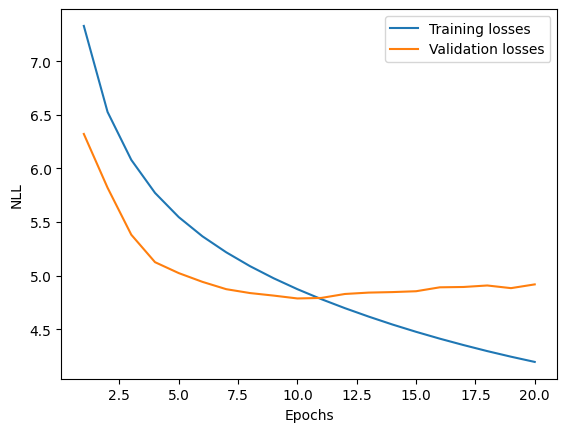

In [136]:
plt.figure()
plt.plot(range(1, trainer.epochs + 1), trainer.train_losses, label='Training losses')
plt.plot(range(1, trainer.epochs + 1), trainer.val_losses[0:20], label='Validation losses')
plt.xlabel('Epochs')
plt.ylabel('NLL')
plt.legend()
plt.show()

# Create handin

In [143]:
# TODO: Generate the handin to submit to autolab
!make runid=1683023828 epoch=10

cp hw4/experiments/1683023828/predictions-test-10.npy predictions.npy
cp hw4/experiments/1683023828/generated-10.txt generated.txt
cp hw4/experiments/1683023828/generated_logits-test-10.npy generated_logits.npy
tar -cvf handin.tar training.ipynb predictions.npy generated.txt generated_logits.npy
tar: training.ipynb: Cannot stat: No such file or directory
predictions.npy
generated.txt
generated_logits.npy
tar: Exiting with failure status due to previous errors
make: *** [Makefile:5: all] Error 2


In [142]:
!pwd

/content/handout
